# Agente Generador de Contexto

En este notebook, mediante el uso de la librería `Lang Graph`, se trabajará en la creación del grafo correspondiente al agente encargado de, mediante el uso de RAG, generar contexto relevante para los futuros agentes, como el creador de SQL y su posterior validador.


---

## Inicialización

### Librerías

In [8]:
import os
import sys
from dotenv import load_dotenv
from pathlib import Path
import json
from IPython.display import Markdown, Image

from collections import defaultdict
from typing import Annotated, Literal, Dict, TypedDict, List, Union, Optional, Any
import operator
from pydantic import BaseModel, Field, ValidationError


from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, ToolMessage, BaseMessage, SystemMessage
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.state import Send
from langgraph.checkpoint.memory import MemorySaver

from langchain.chat_models import init_chat_model
from langchain.prompts import ChatPromptTemplate
from langchain.chains.sql_database.prompt import POSTGRES_PROMPT

from langchain.tools import tool, BaseTool
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent



# Añadimos el directorio raíz del proyecto al path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


from src.back.embeddings import GenAIExtendedEmbeddingFunction
from src.back.chroma_collections import (
    ContextEnricherChromaCollection,
    MdlHierarchicalChromaCollections,
    ExamplesChromaCollection
)




# import warnings
# warnings.filterwarnings('ignore')

### Constantes

In [9]:
TABLES_COLLECTION_NAME = 'mdl_tables_summary'
COLUMNS_COLLECTION_NAME = 'mdl_columns'
BUSINESS_LOGIC_COLLECTION_NAME = 'business_logic'
EXAMPLES_COLLECTION_NAME = 'query_examples'

GENAI_EMBEDDING_MODEL = 'gemini-embedding-001'

MAX_GENERATE_ITERATIONS = 3
MAX_CONTEXT_TOOL_CALLING = 3
MAX_SUBQUERIES_SPLIT = 5

### Modelos a utilizar

In [10]:


llm_graders = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o-mini',
    temperature= 0,
    max_tokens= 1000
)

llm_classifiers = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o-mini',
    temperature= 0,
    max_tokens= 1000
)

llm_retrievals = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o-mini',
    temperature= 0,
    max_tokens= 1000
)

llm_generation = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o',
    temperature= 0,
    max_tokens= 2000
)

---

## Creación de Grafos

### Sub-grafo de Grader & Content Generation

#### LLM's

##### Retrieval Grader

In [11]:
class GradeRetrievalResult(BaseModel):
    """Boolean score for relevance check on retrieved documents."""

    relevant: bool = Field(
        description= "The document is relevant to the question, `true` or `false`"
    )

structured_llm_grader = llm_graders.with_structured_output(GradeRetrievalResult)


grade_system_prompt = """
You are a grader assessing relevance of a retrieved document to a user question.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
If the document contains keyword(s) or semantic meaning related to the user question or its language, grade it as relevant.
Give a binary result 'true' or 'false' to indicate whether the document is relevant to the question.
"""

grade_prompt = ChatPromptTemplate.from_messages([
    ('system', grade_system_prompt),
    ('human', 'Retrieved document:\n{context}\n\nUser user_query:\n{user_query}'),
])

retrieval_grader = grade_prompt | structured_llm_grader

doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

print(doc_txt)
print('-'*100 + '\n')

print('Relevant user_query:')
relevant_user_query = '¿Cuál es el promedio de ventas por producto?'
print(f"'{relevant_user_query}'")
print(retrieval_grader.invoke({"user_query": relevant_user_query, "context": doc_txt}))

print('\n' + '-'*100 + '\n')

print('Relevant user_query:')
relevant_user_query = 'Tell me the average value of sales by products.'
print(f"'{relevant_user_query}'")
print(retrieval_grader.invoke({"user_query": relevant_user_query, "context": doc_txt}))

print('\n' + '-'*100 + '\n')

print('No Relevant user_query:')
not_relevant_user_query = 'Dime el departamento con salario medio mayor'
print(f"'{not_relevant_user_query}'")
print(retrieval_grader.invoke({"user_query": not_relevant_user_query, "context": doc_txt}))


3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto

##### Generate

Diccionario de términos por tipo de consulta:

In [12]:
PROMPT_AJUSTMENT_DICT = {
    'business_logic': {
        'user_query': 'Business Rules related to: ',
        'output': (
            "Your final output should be a single, structured text that begins with the heading 'Synthesized Business Logic'. "
            "Start with a brief, high-level summary. "
            "Follow with a detailed breakdown of each business rule or concept from the context, "
            "using clear headings or bullet points."
        )
    },
    'mdl': {
        'user_query': 'Tables summaries (including their keys) and columns needed to responds: ',
        'output': (
            "Your final output should be a single, structured text with two main sections:"
            "1. A detailed summary of all relevant tables and columns for the query."
            "2. A summary of how to relate these tables, with the option to propose **SQL join conditions** as fragments."
            "3. You are **ABSOLUTELY FORBIDDEN FROM INVENTING, EXTRACTING, OR SUGGESTING any new SQL query or complete SQL code** not "
            "provided in the source material. You may only provide relevant fragments or logical components of SQL that are directly "
            "derived from the table and join information provided in the context."
        )
    }
}

In [13]:
class GenerateContentResult(BaseModel):
    """Relevant content generated from bringed context based in user query."""

    generated_content: str = Field(
        description= "Brief content generated using bringed context."
    )

structured_llm_generator = llm_generation.with_structured_output(GenerateContentResult)


generate_system_prompt = """
You are an expert assistant designed to extract and summarize information from a given text. \
Your task is to analyze the retrieved context in the [CONTEXT] section \
and extract all information relevant to the user's query in [USER_QUERY].

---

### INSTRUCTIONS

1. Analyze the provided information contained within the [CONTEXT] section. \
    Your goal is to identify all topics, details, and **operational rules, definitions, or structural information** \
    that are related to the user's query or its language. This includes, but is not limited to, \
    business rules, logical definitions, data model structures, and data handling protocols.

2. Generate a comprehensive and detailed summary that includes **all** the relevant information found. \
    If the context contains rules on how to handle the query \
    (e.g., how to capture a product name, how to handle null values, specific business logic, or table relationships), \
    include these rules and details in your summary. The summary must be exhaustive, capturing key points \
    and significant details without adding external knowledge.

3. **Only if no information of any kind** (direct answer or operational rules/structures) is relevant to the user's query, \
    state clearly that the context does not contain relevant information.

4. Do not invent or assume information not explicitly present in the [CONTEXT] section. \
    If a specific data point is not mentioned, do not include it and do not comment on its absence.

5. Language: The output MUST be a text in **{language}**.

---

### INPUT

[USER_QUERY]
<user_query>
{user_query}
</user_query>

[CONTEXT]
<context>
{context}
</context>

---

### OUTPUT

{output_requirements}

Ensure every detail from the [CONTEXT] is accounted for and explained in a logical flow.
"""

generate_prompt = ChatPromptTemplate.from_template(generate_system_prompt)

generator = generate_prompt | structured_llm_generator

doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

# doc_txt = '1. Representación de Entidades y Preferencias Lingüísticas\n\nCuando se solicita conceptualmente una entidad, como "productos", "clientes", "promociones" o "revendedores", se establece como principio operativo priorizar los campos que finalizan en `_name` para su adecuada representación en las salidas de las consultas SQL. Adicionalmente, se procurará mantener la coherencia con el idioma en que la consulta original fue formulada.\n\n- Principio Operativo: Para la visualización de entidades en los resultados de consultas, se debe seleccionar el campo `_name` que mejor represente la entidad. En el caso de campos bilingües donde la versión en español (`spanish_...name`, `spanish..._description`) pueda ser nula y la consulta se realice en español, se utilizará la versión en inglés como alternativa (`fallback`) para asegurar la disponibilidad del dato y mantener la representación de la entidad.\n- Lógica SQL (Ejemplo para `dim_product`):\n\n    ```sql\n    -- Selección del nombre del producto en español o, si es NULL, en inglés, para su representación\n    SELECT\n        product_key,\n        COALESCE(spanish_product_name, english_product_name) AS producto_nombre,\n        COALESCE(spanish_product_category_name, english_product_category_name) AS producto_category,\n        COALESCE(spanish_product_subcategory_name, english_product_subcategory_name) AS producto_subcategoria\n    FROM\n        sales.dim_product;```\n\n    Este enfoque se aplicaría de manera similar a la representación de nombres de entidades en `dim_promotion`, `dim_customer`, `dim_reseller`, `dim_sales_person`, `dim_sales_reason`, `dim_sales_territory` y `dim_geography`, siempre privilegiando los campos `_name` relevantes y aplicando la lógica de `fallback` para el idioma.\n\nCuando se trata de campos como `product_line`, `class` y `style` de la  `dim_product`, los cuales pueden contener valores `NULL`, se establece como principio operativo completar los valores faltantes con una etiqueta que indique la ausencia de información, respetando el idioma de la consulta del usuario.\n\n- Principio Operativo: Para la visualización de atributos de productos que puedan ser nulos, se debe reemplazar el valor faltante por un placeholder que indique "no registrado", manteniendo la coherencia con el idioma de la consulta. Por ejemplo, se usará `\'|| No registrado ||\'` para consultas en español y `\'|| Not registered ||\'` para consultas en inglés.\n- Lógica SQL (Ejemplo para `dim_product`):\n\n    ```sql\n    -- Completar valores nulos en atributos de producto según el idioma de la consulta\n    SELECT\n        product_key,\n        COALESCE(product_line, \'|| No registrado ||\') AS producto_linea,\n        COALESCE(class, \'|| No registrado ||\') AS producto_clase,\n        COALESCE(style, \'|| No registrado ||\') AS producto_estilo\n    FROM\n        sales.dim_product;\n    ```'

table_definition = {
        "table_summary": {
            "content": "Database: adventure_works_dw\nSchema: sales\nTable: fact_sales\nTable description: Tabla de hechos que contiene el detalle de las ordenes de ventas que ya han sido entregadas, con una granularidad a nivel de línea, mostrando siempre la última versión de cada pedido. SIEMPRE que se soliciten datos de ventas, como cantidades vendidas, importe de ventas, costes de ventas, impuestos, costes de envío, deberán ser obtenidos de esta tabla. Permite hacer desgloses a nivel de productos, clientes, tiendas/distribuidores, división territorial, promociones aplicadas y vendedores involucrados.\nTable PRIMARY KEY:\n- sales_order_number\n- sales_order_line_number\nTable FOREIGN KEYS (Column name, Reference):\n- (product_key, sales.dim_product.product_key)\n- (reseller_key, sales.dim_reseller.reseller_key)\n- (employee_key, sales.dim_sales_person.employee_key)\n- (customer_key, sales.dim_customer.customer_key)\n- (promotion_key, sales.dim_promotion.promotion_key)\n- (sales_territory_key, sales.dim_sales_territory.sales_territory_key)"
        },
        "columns": [
            {
                "content": "Column name: order_quantity\nColumn data type: INT2\nColumn description: Cantidad vendida de cada producto."
            },
            {
                "content": "Column name: unit_price\nColumn data type: NUMERIC\nColumn description: Precio de venta en USD de cada unidad de producto."
            },
            {
                "content": "Column name: extended_amount\nColumn data type: NUMERIC\nColumn description: Precio de venta en USD de todas las unidades de producto. Se calcula como `order_quantity * unit_price`."
            },
            {
                "content": "Column name: sale_source\nColumn data type: TEXT\nColumn description: Indicador de la fuente por la que ha sido realizado el pedido. 'reseller_sales'=Pedido realizado por un vendedor para una tienda/distribuidor, 'internet_sales'=Pedido realizado en línea por un cliente."
            },
            {
                "content": "Column name: order_date\nColumn data type: DATE\nColumn description: Fecha en la que el pedido fué creado."
            },
            {
                "content": "Column name: freight\nColumn data type: NUMERIC\nColumn description: Coste de envío en USD atribuíble a cada línea de orden de venta. Se reparte el total del coste de envío del pedido proporcionalmente al `sales_amount` de cada una de sus líneas."
            },
            {
                "content": "Column name: ship_date\nColumn data type: DATE\nColumn description: Fecha en la que se envió el pedido al cliente. NUNCA vendrá a NULL, dado que se trata de todos pedidos que ya han sido entregados."
            },
            {
                "content": "Column name: sales_amount\nColumn data type: NUMERIC\nColumn description: Subtotal en USD de la línea de orden de venta. Se calcula como `extended_amount - discount_amount`."
            },
            {
                "content": "Column name: total_product_cost\nColumn data type: NUMERIC\nColumn description: Coste estándar en USD de todas las unidades de producto. Se calcula como `order_quantity * product_standard_cost`."
            },
            {
                "content": "Column name: due_date\nColumn data type: DATE\nColumn description: Fecha en la que el pedido fué entregado al cliente. NUNCA vendrá a NULL, dado que se trata de todos pedidos que ya han sido entregados."
            },
            {
                "content": "Column name: unit_price_discount_pct\nColumn data type: FLOAT8\nColumn description: Porcentaje de descuento aplicado sobre el precio unitario del producto. Está indicado en decimal, es decir, su rango va de 0 a 1."
            },
            {
                "content": "Column name: discount_amount\nColumn data type: FLOAT8\nColumn description: Importe total de descuento en USD. Se calcula como `extended_amount * unit_price_discount_pct`."
            },
            {
                "content": "Column name: tax_amt\nColumn data type: NUMERIC\nColumn description: Importe de impuestos en USD aplicable a la línea de orden de venta."
            },
            {
                "content": "Column name: product_standard_cost\nColumn data type: NUMERIC\nColumn description: Coste estándar en USD de cada unidad de producto."
            }
        ]
    }
# doc_txt = json.dumps(table_definition, indent=2, ensure_ascii=False)

user_query = 'The product most selled.'

entity = list(PROMPT_AJUSTMENT_DICT.keys())[0]
full_user_query = f'{PROMPT_AJUSTMENT_DICT[entity]["user_query"]}"{user_query}".'
output_requirements = PROMPT_AJUSTMENT_DICT[entity]['output']

print("Retrieved context:\n{context}\n\nuser_query:\n{user_query}\n\nAnswer:".format(
    user_query= full_user_query, 
    context= doc_txt
))
print(generator.invoke({
    "user_query": full_user_query,
    "language": 'Spanish',
    "context": doc_txt,
    "output_requirements": output_requirements,
}).generated_content)

Retrieved context:

3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcent

##### Halucionation Grader

In [14]:
class GradeHallucinationResult(BaseModel):
    """Boolean score for hallucination present in generation answer."""

    grounded: bool = Field(
        description= "Answer is grounded in the facts, `true` or `false`"
    )

structured_llm_hallucination = llm_graders.with_structured_output(GradeHallucinationResult)


hallucination_system_prompt = """
You are a grader assessing whether an LLM generation is grounded in / supported by the retrieved context.
ENSSURE THAT GENERATION MUST ONLY USE INFORMATION DIRECTLY FROM THE PROVIDED CONTEXT. \
Pay special attention to the names of fields and tables; the generation must use the exact names as they appear in the context. \
Any deviation, fabrication, or hallucination of field or table names will result in a 'false' score.
Give a binary result 'true' or 'false'. 'true' means that the answer is grounded in / supported by the set of facts.
"""

hallucination_prompt = ChatPromptTemplate.from_messages([
    ('system', hallucination_system_prompt),
    ('human', 'Set of facts:\n{context}\n\nLLM generation:\n{generation}'),
])

hallucination_grader = hallucination_prompt | structured_llm_hallucination

doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

generation = """
In this context, the 'most sold' product is the one with the highest order_quantity (units sold). 
If you are evaluating by revenue, identify the product with the highest sales_amount ('de mayor facturación'). 
To determine the top-selling product, compare order_quantity across products; if revenue is the goal, compare sales_amount.
"""

generation = """The most selled products are those ones from the B2B segment."""

print('Set of facts:\n\n{context}\n\nLLM generation:\n{generation}'.format(
    generation= generation,
    context= doc_txt
))
print(hallucination_grader.invoke({"generation": generation, "context": doc_txt}))

Set of facts:


3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje 

##### Relevant Answer

In [15]:
class GradeAnswerResult(BaseModel):
    """Boolean score to assess answer addresses question."""

    addresses: bool = Field(
        description= "Answer addresses the question, `true` or `false`"
    )

structured_llm_answer_grader = llm_graders.with_structured_output(GradeAnswerResult)


answer_grade_system_prompt = """
You are a grader assessing whether an answer provides information relevant to a question.
Your task is not to determine if the question is fully resolved, \
but if the answer offers useful information about the topic of the question.
Give a binary result 'true' or 'false'. 'true' means that the answer contains relevant information.
"""

answer_grade_prompt = ChatPromptTemplate.from_messages([
    ('system', answer_grade_system_prompt),
    ('human', 'User user_query:\n{user_query}\n\nLLM generation:\n{generation}'),
])

answer_grader = answer_grade_prompt | structured_llm_answer_grader

user_query = 'The product most selled.'

generation = """
In this context, the 'most sold' product is the one with the highest order_quantity (units sold). 
If you are evaluating by revenue, identify the product with the highest sales_amount ('de mayor facturación'). 
To determine the top-selling product, compare order_quantity across products; if revenue is the goal, compare sales_amount.
"""

print('user_query:\n{user_query}\n\nLLM generation:\n{generation}'.format(
    user_query= user_query,
    generation= generation
))
print(answer_grader.invoke({"user_query": user_query, "generation": generation}))

user_query:
The product most selled.

LLM generation:

In this context, the 'most sold' product is the one with the highest order_quantity (units sold). 
If you are evaluating by revenue, identify the product with the highest sales_amount ('de mayor facturación'). 
To determine the top-selling product, compare order_quantity across products; if revenue is the goal, compare sales_amount.

addresses=True


#### Estado

In [16]:
class GradeGenerationState(TypedDict):
    user_query: str
    language: str
    entity: str
    context: str
    generate_iterations: int
    generation: List[str]

class GradeGenerationOutputState(TypedDict):
    generation: List[str]

#### Nodos

In [17]:
def generate_from_context(state: GradeGenerationState):
    """
    Generate relevant content for question based in context.

    Args:
        state (dict): The current graph state
    """
    print("---GENERATE---")
    user_query = state['user_query']
    language = state['language']
    entity = state.get('entity')
    context = state['context']
    generate_iterations = state.get('generate_iterations', 0)

    full_user_query = user_query
    output_requirements = ''
    if entity:
        full_user_query = (
            user_query
            if user_query.strip().upper().startswith(
                PROMPT_AJUSTMENT_DICT[entity]['user_query'].strip().upper()
            ) else
            f'{PROMPT_AJUSTMENT_DICT[entity]["user_query"]}"{user_query}".'
        )

        output_requirements = PROMPT_AJUSTMENT_DICT[entity]['output']


    generation = generator.invoke({
        "language": language,
        "user_query": full_user_query,
        "context": context,
        "output_requirements": output_requirements,
    }).generated_content

    return {
        'generation': [generation],
        'generate_iterations': generate_iterations + 1
    }


def set_grade_output_ko(state: GradeGenerationState) -> dict[str, list]:
    print("---SET GRADE OUTPUT KO---")
    
    return {
        'generation': ['[NO RELEVANT CONTENT]']
    }

#### Conditional Edges

In [59]:
def grade_context(state: GradeGenerationState) -> Literal['generate', 'output_ko']:
    """
    Determines whether the retrieved document is relevant to the question.
    If it's, then proceed to generate content, else, go to end.

    Args:
        state: The current graph state

    Returns:
        Decision for next node to call
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    user_query = state['user_query']
    entity = state.get('entity')
    context = state['context']

    full_user_query = user_query
    if entity:
        full_user_query = (
            user_query
            if user_query.strip().upper().startswith(
                PROMPT_AJUSTMENT_DICT[entity]['user_query'].strip().upper()
            ) else
            f'{PROMPT_AJUSTMENT_DICT[entity]["user_query"]}"{user_query}"'
        )
    
    relevant = retrieval_grader.invoke({'user_query': full_user_query, 'context': context}).relevant

    if relevant == True:
        print("---GRADE: DOCUMENT RELEVANT---")
        return 'generate'
    
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        return 'output_ko'



def grade_generation(state: GradeGenerationState) -> Literal['generate', 'output_ko', '__end__']:
    """
    Determines whether the generation is grounded in the 
    document and informative for question.

    Args:
        state (dict): The current graph state

    Returns:
        Decision for next node to call
    """
    print("---CHECK ITERATIONS---")
    generate_iterations = state['generate_iterations']

    if generate_iterations == MAX_GENERATE_ITERATIONS:
        return 'output_ko'


    print("---CHECK HALLUCINATIONS---")

    user_query = state['user_query']
    entity = state.get('entity')
    context = state['context']
    generation = state['generation'][0]

    grounded = hallucination_grader.invoke(
        {'context': context, 'generation': generation}
    ).grounded

    if grounded == True:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")


        full_user_query = user_query
        if entity:
            full_user_query = (
                user_query
                if user_query.strip().upper().startswith(
                    PROMPT_AJUSTMENT_DICT[entity]['user_query'].strip().upper()
                ) else
                f'{PROMPT_AJUSTMENT_DICT[entity]["user_query"]}"{user_query}"'
            )
        addresses = answer_grader.invoke({
            'user_query': full_user_query,
            'generation': generation
        }).addresses

        if addresses == True:
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return '__end__'
        
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")

    return 'generate'

#### Grafo

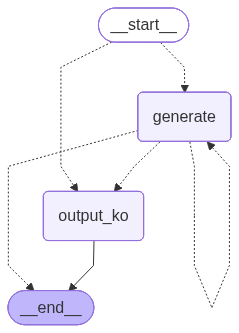

In [60]:
grading_generation_graph = StateGraph(
    state_schema= GradeGenerationState,
    input_schema= GradeGenerationState,
    output_schema= GradeGenerationOutputState
)

grading_generation_graph.add_node('generate', generate_from_context)
grading_generation_graph.add_node('output_ko', set_grade_output_ko)

grading_generation_graph.add_conditional_edges(
    START,
    grade_context
)
grading_generation_graph.add_conditional_edges(
    'generate',
    grade_generation
)
grading_generation_graph.add_edge('output_ko', END)


grading_generation_graph= grading_generation_graph.compile()

display(Image(grading_generation_graph.get_graph().draw_mermaid_png()))

In [20]:
doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

user_query = 'The name of the product most selled.'

grading_generation_graph.invoke({
    "user_query": user_query,
    "language": 'English',
    "entity": 'business_logic',
    "context": doc_txt, 
})

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


{'generation': ['Synthesized Business Logic\n\nThe context provides detailed information regarding metrics and their interpretation in the retail business domain. Specifically, it addresses the concept of "most sold products" and related metrics. Below is the synthesized information:\n\n- **Definition of "Most Sold Products"**:\n  - When referring to "most sold products," the metric typically used is the quantity of units sold (`order_quantity`).\n  - Alternatively, products can be evaluated based on the revenue generated (`sales_amount`), which identifies products contributing the most income, even if sold in lower volumes. This is explicitly termed as "highest revenue-generating products."\n\n- **Additional Metrics and Context**:\n  - For profitability analysis, metrics such as gross margin (`gross margin`) or gross margin percentage (`gross margin percentage`) are used to assess the actual contribution of products to profits.\n  - Promotional success is measured not only by discount

### Sub-grafo de Business Logic Retrieval

#### Tool

Definimos las la colección de Chroma que utilizaremos en nuestra tool:

In [24]:
genai_embeddings = GenAIExtendedEmbeddingFunction(model= GENAI_EMBEDDING_MODEL)
print(f'VertexAI: {genai_embeddings.genai_client._api_client.vertexai}')
print(f'Project: {genai_embeddings.genai_client._api_client.project}')
print(f'Location: {genai_embeddings.genai_client._api_client.location}')
print(f'Auth Tokens: {genai_embeddings.genai_client.auth_tokens}')


business_logic_collection = ContextEnricherChromaCollection(
    collection_name= BUSINESS_LOGIC_COLLECTION_NAME,
    embedding_function= genai_embeddings,
    host= os.getenv('CHROMA_SERVER_HOST'),
    port= os.getenv('CHROMA_LOCAL_PORT')
)

VertexAI: True
Project: gen-lang-client-0151767776
Location: europe-west1
Auth Tokens: <google.genai.tokens.Tokens object at 0x0000018BABA985D0>


Definimos el esquema que deberá utilizar el LLM para llamar a la tool:

In [25]:
class RetrieverInput(BaseModel):
    """
    Input schema for retriever tools. Accepts one or more queries for retrieval.
    """
    queries: List[str] = Field(
        description= (
            "A list of one or more search queries to retrieve relevant information. "
            f"Break down the user's question into up to {MAX_SUBQUERIES_SPLIT} simple, focused sub-queries to maximize retrieval accuracy. "
            "Each sub-query should represent a key concept from the original question."
        )
    )

Procedemos a crear la tool que nos permitirá hacer retrival de los documentos de lógica de negocio relevantes para la consulta del usuario:

In [26]:
@tool("business_logic_retriever", args_schema=RetrieverInput)
def get_business_logic(queries: List[str]) -> List[str]:
    """
    Retrieve detailed business logic, including KPI calculations, domain-specific rules, and definitions of business concepts.
    This is the primary source for understanding the semantic meaning and 'why' behind the data. 
    Provide multiple queries to cover all relevant business aspects.
    """

    search_results = business_logic_collection.enriched_context_search(
        queries= queries,
        context_window_size= 3,
        merge_results= True,
        search_type= 'mmr',
        k= 10,
        fetch_k= 25,
        lambda_mult= 0.5
    )

    if not search_results:
        return ['No semantically relevant results were found for the specified queries.']

    return search_results

#### LLM's

##### Business Logic Retriever

Usamos el esquema definido para el input de las tools de retrieval como esquema de salida de este agente.

In [27]:
business_logic_retrieval_prompt = """
You are an AI agent tasked with retrieving semantically \
relevant business logic from a vector database.

Your sole function is to decompose the user's original query into a maximum \
of {max_queries} semantically distinct sub-queries.
"""

business_logic_prompt = ChatPromptTemplate.from_messages([
    ('system', business_logic_retrieval_prompt),
    ('human', 'User user_query:\n{user_query}'),
])


structured_llm_business_logic_retriever = llm_retrievals.with_structured_output(RetrieverInput)

retrieval_business_logic = business_logic_prompt | structured_llm_business_logic_retriever

user_query = '¿Cuál es el promedio de ventas por producto?'
retrieval_business_logic.invoke({'max_queries': MAX_SUBQUERIES_SPLIT, 'user_query': user_query}).queries

['Promedio de ventas por producto',
 'Cálculo de ventas promedio',
 'Datos de ventas por producto',
 'Análisis de ventas por producto',
 'Estadísticas de ventas promedio']

##### Business Logic Summarizer

Usamos el esquema asociado a generadores creado en la sección anterior.

In [28]:
class BusinessLogicSummaryResult(BaseModel):
    """Relevant summary generated from document retrival based in user query."""

    generated_summary: str = Field(
        description= "Summary of the relevant content in business logic chunks retrieval."
    )

structured_llm_business_logic_summarizer = llm_generation.with_structured_output(BusinessLogicSummaryResult)


business_logic_summarizer_system_prompt = """
You're a highly precise and diligent Business Logic Synthesis Agent. \
Your sole purpose is to process and synthesize complex business logic information \
provided as context for a given user query. Your goal is to produce a single, \
comprehensive, and detailed output that consolidates all the provided information.

---

### INSTRUCTIONS

1. Strictly Adhere to Context: Your response must be derived exclusively from the \
    information contained within the [CONTEXT] section. You MUST NOT invent, infer, \
    or hallucinate any details, rules, or logic that are not explicitly present in the provided extracts.

2. Handle Lack of Context: If a context extract explicitly states that no relevant information \
    is available for a specific topic, you must ignore that extract. \
    If all provided context extracts state that no relevant information is available, \
    your final output must be a single, brief sentence stating that no relevant business \
    logic was found for the user's query.

3. Ensure Full Coverage: Every single piece of information, every rule, and every topic \
    mentioned in the [CONTEXT] must be incorporated into your final output. \
    Leave no topic unaddressed.

4. SQL Handling & Language Adaptation: You MUST INCLUDE any SQL fragments or clauses \
    that are explicitly present in the [CONTEXT]. You are FORBIDDEN from inventing, extracting, \
    or suggesting any new SQL code not provided in the source material. You may only provide relevant \
    fragments or logical components of SQL that are directly derived from the business logic provided \
    in the context. If the context provides language-specific information (e.g., placeholder values \
    or SQL fragments) that do not match the {language} of the user's query, you MUST translate or adapt \
    this information to the target language. For example, if the query is in English and a rule mentions \
    a placeholder "No registrado," you should adapt it to a relevant English equivalent like "Not Registered."

5. Language: The output MUST be a text in **{language}**.

6. Purpose-Oriented Output: The final output is intended for a data analyst who will use \
    it to build a structured SQL query. Therefore, the response must be clear, precise, \
    and contain all the necessary details to represent the business rules accurately. \
    Organize the information logically using headings, subheadings, and bullet points to \
    facilitate easy understanding and translation into a query structure.

---

### INPUT

[USER_QUERY]
<user_query>
{user_query}
</user_query>

[CONTEXT]
<context>
{context}
</context>

---

### OUTPUT
Your final output should be a single, structured text that begins with the heading \
"Synthesized Business Logic". Start with a brief, high-level summary. \
Follow with a detailed breakdown of each business rule or concept from the context, \
using clear headings or bullet points.

Ensure every detail from the [CONTEXT] is accounted for and explained in a logical flow.
"""

business_logic_summary_prompt = ChatPromptTemplate.from_template(
    business_logic_summarizer_system_prompt
)

business_logic_summarizer = business_logic_summary_prompt | structured_llm_business_logic_summarizer

doc_txt = [
    """
    3. Métricas Clásicas del Retail y su Interpretación

    Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
    - Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
    - Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
    - En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
    - Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
    - Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
    """,
    """
    1. Representación de Entidades y Preferencias Lingüísticas

    Cuando se solicita conceptualmente una entidad, como "productos", "clientes", "promociones" o "revendedores", se establece como principio operativo priorizar los campos que finalizan en `_name` para su adecuada representación en las salidas de las consultas SQL. Adicionalmente, se procurará mantener la coherencia con el idioma en que la consulta original fue formulada.

    - Principio Operativo: Para la visualización de entidades en los resultados de consultas, se debe seleccionar el campo `_name` que mejor represente la entidad. En el caso de campos bilingües donde la versión en español (`spanish_...name`, `spanish..._description`) pueda ser nula y la consulta se realice en español, se utilizará la versión en inglés como alternativa (`fallback`) para asegurar la disponibilidad del dato y mantener la representación de la entidad.
    - Lógica SQL (Ejemplo para `dim_product`):

        ```sql
        -- Selección del nombre del producto en español o, si es NULL, en inglés, para su representación
        SELECT
            product_key,
            COALESCE(spanish_product_name, english_product_name) AS producto_nombre,
            COALESCE(spanish_product_category_name, english_product_category_name) AS producto_category,
            COALESCE(spanish_product_subcategory_name, english_product_subcategory_name) AS producto_subcategoria
        FROM
            sales.dim_product;```

        Este enfoque se aplicaría de manera similar a la representación de nombres de entidades en `dim_promotion`, `dim_customer`, `dim_reseller`, `dim_sales_person`, `dim_sales_reason`, `dim_sales_territory` y `dim_geography`, siempre privilegiando los campos `_name` relevantes y aplicando la lógica de `fallback` para el idioma.

    Cuando se trata de campos como `product_line`, `class` y `style` de la  `dim_product`, los cuales pueden contener valores `NULL`, se establece como principio operativo completar los valores faltantes con una etiqueta que indique la ausencia de información, respetando el idioma de la consulta del usuario.

    - Principio Operativo: Para la visualización de atributos de productos que puedan ser nulos, se debe reemplazar el valor faltante por un placeholder que indique "no registrado", manteniendo la coherencia con el idioma de la consulta. Por ejemplo, se usará `'|| No registrado ||'` para consultas en español y `'|| Not registered ||'` para consultas en inglés.
    - Lógica SQL (Ejemplo para `dim_product`):

        ```sql
        -- Completar valores nulos en atributos de producto según el idioma de la consulta
        SELECT
            product_key,
            COALESCE(product_line, '|| No registrado ||') AS producto_linea,
            COALESCE(class, '|| No registrado ||') AS producto_clase,
            COALESCE(style, '|| No registrado ||') AS producto_estilo
        FROM
            sales.dim_product;
        ```
    """
]

user_query = 'The product most selled.'

context = '\n\n---\n\n'.join(doc_txt)

print(business_logic_summarizer.invoke({
    "user_query": user_query,
    "language": 'English',
    "context": context
}).generated_summary)

### Synthesized Business Logic

#### High-Level Summary
The query pertains to identifying the "most sold" product, which is determined by the quantity of units sold (`order_quantity`).

#### Detailed Breakdown

- **Metric Definition**:
  - "Most sold" products are identified based on the quantity of units sold (`order_quantity`).
  - Alternatively, products can be ranked by revenue generated (`sales_amount`) if specified as "highest revenue".

- **Entity Representation**:
  - For product representation, prioritize fields ending in `_name`.
  - Use bilingual fallback logic for product names, selecting the Spanish name (`spanish_product_name`) or defaulting to the English name (`english_product_name`) if the Spanish name is null.

- **SQL Example for Product Representation**:
  ```sql
  SELECT
      product_key,
      COALESCE(spanish_product_name, english_product_name) AS producto_nombre
  FROM
      sales.dim_product;
  ```

This synthesized logic provides the necessary details to cons

#### Estado

In [29]:
class BusinessLogicState(TypedDict):
    user_query: str
    language: str
    entity: str
    sub_queries: List[str]
    retieval_iterations: int
    retrieval_results: List[str]
    business_logic_retrieval_results: List[str]
    generation: Annotated[List[str], operator.add]
    business_logic: str

class BusinessLogicOutputState(TypedDict):
    business_logic_retrieval_results: List[str]
    business_logic: str

#### Nodos

In [30]:
def generate_business_logic_sub_queries(state: BusinessLogicState):
    """
    Create relevant sub-queries for the user question to improve retrieval.

    Args:
        state (dict): The current graph state
    """
    print("---BUSINESS LOGIC SUB-QUERIES---")
    user_query = state['user_query']
    entity = state.get('entity', 'business_logic')
    retieval_iterations = state.get('retieval_iterations', 0)
    
    sub_queries = retrieval_business_logic.invoke({
            'max_queries': MAX_SUBQUERIES_SPLIT,
            'user_query': user_query
    }).queries

    return {
        'entity': entity,
        'sub_queries': sub_queries,
        'retieval_iterations': retieval_iterations + 1,
    }


def retrieve_business_logic_queries(state: BusinessLogicState):
    """
    Execute tool to retrieve business logic results.

    Args:
        state (dict): The current graph state
    """
    print("---BUSINESS LOGIC RETRIEVE TOOL---")
    queries = state['sub_queries']
    
    retrieval_results = get_business_logic.invoke(input= {'queries': queries})

    return {
        'retrieval_results': retrieval_results,
        'business_logic_retrieval_results': retrieval_results
    }


def summarize_business_logic(state: BusinessLogicState):
    """
    Consolidate business logic context summaries.

    Args:
        state (dict): The current graph state
    """
    print("---BUSINES LOGIC SUMMARIZING---")
    
    user_query = state['user_query']
    language = state["language"]
    generation = [
        generation_result 
        for generation_result in state['generation']
        if generation_result != '[NO RELEVANT CONTENT]'
    ]

    if not generation:
        return {
            'business_logic': 'Business logic for this request was not found. Please try a different query.'
        }


    context = '\n\n---\n\n'.join(generation)

    business_logic_summary = business_logic_summarizer.invoke({
        "user_query": user_query, 
        "language": language,
        "context": context
    }).generated_summary

    return {
        'business_logic': business_logic_summary
    }


# def set_business_logic_ko(state: BusinessLogicState):
#     print("---SET BUSINESS LOGIC OUTPUT KO---")
    
#     return {
#         'business_logic': 'Business logic for this request was not found. Please try a different query.'
#     }

#### Conditional Edges

In [31]:
def send_to_parallel_grade(state):
    """
    Conditional edge to reach generation parallelization.

    Args:
        state (dict): The current graph state
    """
    print("---PARALLELIZE GENERATION---")

    user_query = state['user_query']
    language = state['language']
    entity = state['entity']
    retrieval_results = state['retrieval_results']

    return [
        Send('grade_retrieval', {
            'user_query': user_query,
            'language': language,
            'context': context,
            'entity': entity
        })
        for context in retrieval_results
    ]


# def exists_generation(state: GradeGenerationState) -> Literal['summarizer', 'output_ko']:
#     """
#     Determines if exists any generation created in sub-graph.

#     Args:
#         state (dict): The current graph state

#     Returns:
#         Decision for next node to call
#     """
#     # print("---CHECK ITERATIONS---")
#     # generate_iteration = state['generate_iterations']

#     # if generate_iteration == MAX_GENERATE_ITERATIONS:
#     #     return 'output_ko'


#     print("---CHECK EXISTING GENERATION---")
#     generation = state['generation']

#     print(f'{generation=}')

#     if [context for context in generation if context != '[NO RELEVANT CONTENT]']:
#         print("---GENERATION EXISTS - CONTINUE TO SUMMARIZE---")
#         return 'summarizer'
    
#     else:
#         print("---GENERATION NOT EXISTS - CONTINUE OUTPUT KO---")
#         return 'output_ko'

#### Grafo

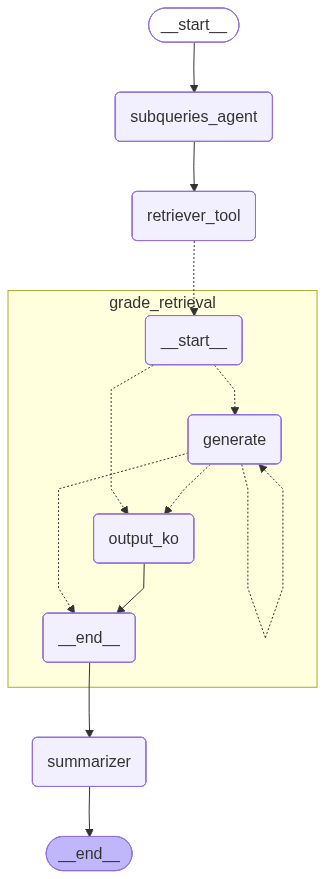

In [68]:
business_logic_graph = StateGraph(
    state_schema= BusinessLogicState,
    input_schema= BusinessLogicState,
    output_schema= BusinessLogicOutputState
)

business_logic_graph.add_node('subqueries_agent', generate_business_logic_sub_queries)
business_logic_graph.add_node('retriever_tool', retrieve_business_logic_queries)
business_logic_graph.add_node('grade_retrieval', grading_generation_graph)
business_logic_graph.add_node('summarizer', summarize_business_logic)
# business_logic_graph.add_node('output_ko', set_business_logic_ko)

business_logic_graph.add_edge(START, 'subqueries_agent')
business_logic_graph.add_edge('subqueries_agent', 'retriever_tool')
business_logic_graph.add_conditional_edges('retriever_tool', send_to_parallel_grade, ['grade_retrieval'])
# business_logic_graph.add_conditional_edges('grade_retrieval', exists_generation)
business_logic_graph.add_edge('grade_retrieval', 'summarizer')
business_logic_graph.add_edge('summarizer', END)
# business_logic_graph.add_edge('output_ko', END)


business_logic_graph = business_logic_graph.compile()

display(Image(business_logic_graph.get_graph(xray=1).draw_mermaid_png()))

In [69]:
user_query = 'The name of the product with highest sales.'

business_logic_test = business_logic_graph.invoke({
    "user_query": user_query,
    'language': 'English'
})['business_logic']

Markdown(business_logic_test)

---BUSINESS LOGIC SUB-QUERIES---
---BUSINESS LOGIC RETRIEVE TOOL---
---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---


Synthesized Business Logic

### Summary
The query seeks to identify the name of the product with the highest sales. The context provides detailed business logic and SQL principles to address this query.

### Business Rules

#### Sales Metrics
- **Most Sold Products**: Defined by the quantity of units sold (`order_quantity`).
- **Highest Revenue Products**: Defined by the revenue generated (`sales_amount`).

#### Profitability Analysis
- Metrics such as `gross margin` and `gross margin percentage` evaluate profitability.

#### Sales Contexts
- **B2C (Business-to-Consumer)**: Transactions identified by `sale_source = 'internet_sales'`.
- **B2B (Business-to-Business)**: Transactions identified by `sale_source = 'reseller_sales'`.

#### Entity Representation
- **Field Prioritization**: Use fields ending in `_name` for product representation.
- **Language Consistency**: Use `spanish_product_name` with fallback to `english_product_name` if null.

#### Handling Null Values
- Replace null values in fields like `product_line`, `class`, and `style` with placeholders such as "Not Registered".

### SQL Application
To determine the product name with the highest sales:
- Use the `_name` field for product representation, applying language fallback.
- Identify the product with the highest `order_quantity` or `sales_amount` based on the metric chosen.
- Handle null values appropriately.

### SQL Example
```sql
SELECT
    COALESCE(spanish_product_name, english_product_name) AS product_name
FROM
    sales.dim_product
WHERE
    product_key = (
        SELECT product_key
        FROM sales.fact_sales
        ORDER BY order_quantity DESC
        LIMIT 1
    );
```

### Sub-grafo de MDL Model Retrieval

#### Tool

Definimos la colección de Chroma que utilizaremos en nuestra tool:

In [34]:
genai_embeddings = GenAIExtendedEmbeddingFunction(model= GENAI_EMBEDDING_MODEL)
print(f'VertexAI: {genai_embeddings.genai_client._api_client.vertexai}')
print(f'Project: {genai_embeddings.genai_client._api_client.project}')
print(f'Location: {genai_embeddings.genai_client._api_client.location}')
print(f'Auth Tokens: {genai_embeddings.genai_client.auth_tokens}')

mdl_collection = MdlHierarchicalChromaCollections(
    collection_names= (TABLES_COLLECTION_NAME, COLUMNS_COLLECTION_NAME),
    embedding_function= genai_embeddings,
    host= os.getenv('CHROMA_SERVER_HOST', 'localhost'),
    port= os.getenv('CHROMA_LOCAL_PORT', '8000')
)

VertexAI: True
Project: gen-lang-client-0151767776
Location: europe-west1
Auth Tokens: <google.genai.tokens.Tokens object at 0x0000018BABB28D90>


Utilizaremos la clase ya creada en la sección anterior.

Procedemos a crear la tool que nos permitirá hacer retrival de los documentos de lógica de negocio relevantes para la consulta del usuario:

In [35]:
@tool("mdl_data_retriever", args_schema=RetrieverInput)
def get_mdl_data(queries: List[str]) -> List[Dict[str, str]]:
    """
    Retrieve table schemas, column definitions, primary and foreign keys. 
    This tool is essential for identifying the specific tables and columns required to construct a valid SQL query. 
    It provides the 'what' and 'where' of the data.
    """

    search_results = mdl_collection.hierarchical_similarity_search(
        queries= queries,
        merge_results= True,
        show_relevance_score= False,
        k_tables= 10,
        tables_score_threshold= 0.75,
        k_columns= 15,
        columns_score_threshold= 0.75
    )

    if not search_results:
        return 'No semantically relevant results were found for the specified queries.'

    return search_results

#### LLM's

##### MDL Model Retriever

Utilizamos el esquema definido junto a la tool.

In [36]:
mdl_retrieval_prompt = """
You are an AI agent tasked with retrieving semantically \
relevant tables summaries and columns details from a vector database.

Your sole function is to decompose the user's original query into a maximum \
of {max_queries} semantically distinct sub-queries.
"""

mdl_prompt = ChatPromptTemplate.from_messages([
    ('system', mdl_retrieval_prompt),
    ('human', 'User user_query:\n{user_query}'),
])


structured_llm_mdl_retriever = llm_retrievals.with_structured_output(RetrieverInput)

retrieval_mdl = mdl_prompt | structured_llm_mdl_retriever

user_query = '¿Cuál es el promedio de ventas por producto?'
retrieval_mdl.invoke({'max_queries': MAX_SUBQUERIES_SPLIT, 'user_query': user_query}).queries

['promedio de ventas por producto',
 'ventas por producto',
 'análisis de ventas por producto',
 'estadísticas de ventas por producto',
 'información sobre ventas promedio']

##### MDL Model Summarizer

In [37]:
class MdlModelSummaryResult(BaseModel):
    """Relevant summary generated from document retrival based in user query."""

    generated_summary: str = Field(
        description= "Summary of the relevant content in tables summaries and columns details retrieval."
    )

structured_llm_mdl_summarizer = llm_generation.with_structured_output(MdlModelSummaryResult)


mdl_summarizer_system_prompt = """
You're a highly precise and diligent Data Schema Synthesis Agent. \
Your sole purpose is to process and synthesize complex data schema information \
about database tables and columns provided as context for a given user query. \
Your goal is to produce a single, comprehensive, and detailed output \
that consolidates all the provided information, **including whether a column can have null values.**

---

### INSTRUCTIONS

1. Strictly Adhere to Context: Your response must be derived exclusively from the \
    information contained within the [CONTEXT] section. You MUST NOT invent, infer, \
    or hallucinate any details, tables, or columns that are not explicitly present \
    in the provided context. **This includes all column attributes, such as data type, \
    primary key status, and nullability (whether it can contain NULL values).**

2. Handle Lack of Context: If a context extract explicitly states that no relevant information \
    is available, you must ignore that extract. If all provided context extracts state that no \
    relevant information is available, your final output must be a single, brief sentence stating \
    that no relevant tables or columns were found for the user's query.

3. Ensure Full Coverage: Every single piece of relevant information, every relevant table description, \
    and every relevant column mentioned in the [CONTEXT] must be incorporated into your final output. \
    Leave no detail unaddressed. **This includes reporting on all available column properties, \
    especially whether a column can be NULL.**

4. Prioritize Inclusion: You **MUST** prioritize providing all columns that are potentially relevant, \
    including similar columns (e.g., in different languages) over the risk of omitting valuable information. \
    The relevance of a column is determined by its name and description, not by the language of the user's query.

5. SQL Handling: You **MUST INCLUDE** any SQL fragments or clauses that are **explicitly present** in the [CONTEXT]. \
    You are **ABSOLUTELY FORBIDDEN FROM INVENTING, EXTRACTING, OR SUGGESTING any new SQL query or complete SQL code** not \
    provided in the source material. You may only provide relevant fragments or logical components of SQL that are directly \
    derived from the table and join information provided in the context.

6. Language: The output MUST be a text in **{language}**.

7. Purpose-Oriented Output: The final output is intended for a data analyst who will use \
    it to build a structured SQL query. Therefore, the response must be clear, precise, \
    and contain all the necessary details to represent the table structure and relationships accurately. \
    Organize the information logically using markdown headings, subheadings, and bullet points to \
    facilitate easy understanding and translation into a query structure.

---

### INPUT

[USER_QUERY]
<user_quer>
{user_query}
</user_quer>

[CONTEXT]
<context>
{context}
</context>

---

### OUTPUT
Your final output should be a single, structured text with two main sections:
1. A detailed summary of all relevant tables and columns for the query, \
    making sure to specify if each column can be NULL.
2. A summary of how to relate these tables, with the option to propose **SQL join conditions** as fragments.

Ensure every detail from the [CONTEXT] is accounted for and explained in a logical flow.
"""

mdl_summary_prompt = ChatPromptTemplate.from_template(
    mdl_summarizer_system_prompt
)

mdl_summarizer = mdl_summary_prompt | structured_llm_mdl_summarizer

doc_txt = [
    {
        "table_summary": {
            "content": "Database: adventure_works_dw\nSchema: sales\nTable: fact_sales\nTable description:  de hechos que contiene el detalle de las ordenes de ventas que ya han sido entregadas, con una granularidad a nivel de línea, mostrando siempre la última versión de cada pedido. SIEMPRE que se soliciten datos de ventas, como cantidades vendidas, importe de ventas, costes de ventas, impuestos, costes de envío, deberán ser obtenidos de esta . Permite hacer desgloses a nivel de productos, clientes, tiendas/distribuidores, división territorial, promociones aplicadas y vendedores involucrados.\nTable PRIMARY KEY:\n- sales_order_number\n- sales_order_line_number\nTable FOREIGN KEYS (Column name, Reference):\n- (product_key, sales.dim_product.product_key)\n- (reseller_key, sales.dim_reseller.reseller_key)\n- (employee_key, sales.dim_sales_person.employee_key)\n- (customer_key, sales.dim_customer.customer_key)\n- (promotion_key, sales.dim_promotion.promotion_key)\n- (sales_territory_key, sales.dim_sales_territory.sales_territory_key)"
        },
        "columns": [
            {
                "content": "Column name: order_quantity\nColumn data type: INT2\nColumn description: Cantidad vendida de cada producto."
            },
            {
                "content": "Column name: unit_price\nColumn data type: NUMERIC\nColumn description: Precio de venta en USD de cada unidad de producto."
            },
            {
                "content": "Column name: extended_amount\nColumn data type: NUMERIC\nColumn description: Precio de venta en USD de todas las unidades de producto. Se calcula como `order_quantity * unit_price`."
            },
            {
                "content": "Column name: sale_source\nColumn data type: TEXT\nColumn description: Indicador de la fuente por la que ha sido realizado el pedido. 'reseller_sales'=Pedido realizado por un vendedor para una tienda/distribuidor, 'internet_sales'=Pedido realizado en línea por un cliente."
            },
            {
                "content": "Column name: order_date\nColumn data type: DATE\nColumn description: Fecha en la que el pedido fué creado."
            },
            {
                "content": "Column name: freight\nColumn data type: NUMERIC\nColumn description: Coste de envío en USD atribuíble a cada línea de orden de venta. Se reparte el total del coste de envío del pedido proporcionalmente al `sales_amount` de cada una de sus líneas."
            },
            {
                "content": "Column name: ship_date\nColumn data type: DATE\nColumn description: Fecha en la que se envió el pedido al cliente. NUNCA vendrá a NULL, dado que se trata de todos pedidos que ya han sido entregados."
            },
            {
                "content": "Column name: sales_amount\nColumn data type: NUMERIC\nColumn description: Subtotal en USD de la línea de orden de venta. Se calcula como `extended_amount - discount_amount`."
            },
            {
                "content": "Column name: total_product_cost\nColumn data type: NUMERIC\nColumn description: Coste estándar en USD de todas las unidades de producto. Se calcula como `order_quantity * product_standard_cost`."
            },
            {
                "content": "Column name: due_date\nColumn data type: DATE\nColumn description: Fecha en la que el pedido fué entregado al cliente. NUNCA vendrá a NULL, dado que se trata de todos pedidos que ya han sido entregados."
            },
            {
                "content": "Column name: unit_price_discount_pct\nColumn data type: FLOAT8\nColumn description: Porcentaje de descuento aplicado sobre el precio unitario del producto. Está indicado en decimal, es decir, su rango va de 0 a 1."
            },
            {
                "content": "Column name: discount_amount\nColumn data type: FLOAT8\nColumn description: Importe total de descuento en USD. Se calcula como `extended_amount * unit_price_discount_pct`."
            },
            {
                "content": "Column name: tax_amt\nColumn data type: NUMERIC\nColumn description: Importe de impuestos en USD aplicable a la línea de orden de venta."
            },
            {
                "content": "Column name: product_standard_cost\nColumn data type: NUMERIC\nColumn description: Coste estándar en USD de cada unidad de producto."
            }
        ]
    },
    {
        "table_summary": {
            "content": "Database: adventure_works_dw\nSchema: sales\nTable: dim_product\nTable description:  de dimensión que almacena la información detallada de cada producto que alguna vez haya sido vendido. Relevante para cualquier consulta en la que se nos pida listar productos por su nombre.\nTable PRIMARY KEY:\n- product_key"
        },
        "columns": [
            {
                "content": "Column name: list_price\nColumn data type: NUMERIC\nColumn description: Precio de venta del producto en USD."
            },
            {
                "content": "Column name: active\nColumn data type: BOOL\nColumn description: Indicador de si el producto sigue disponible para la venta."
            },
            {
                "content": "Column name: finished_goods_flag\nColumn data type: BOOL\nColumn description: Indicador de si se trata de un producto final vendible. '0'=El producto no es un artículo vendible, '1'=El producto es vendible."
            },
            {
                "content": "Column name: spanish_product_category_name\nColumn data type: VARCHAR(50)\nColumn description: Categoría principal a la que pertenece el producto (ESPAÑOL). Las categorías son 'Prenda', 'Componente', 'Accesorio' y 'Bicicleta'  NUNCA viene a NULL."
            },
            {
                "content": "Column name: english_product_category_name\nColumn data type: VARCHAR(50)\nColumn description: Categoría principal a la que pertenece el producto (INGLÉS). Las categorías son 'Clothing', 'Components', 'Accessories' y 'Bikes'. NUNCA viene a NULL."
            },
            {
                "content": "Column name: style\nColumn data type: BPCHAR(2)\nColumn description: Público para el que está pensado el producto. 'W'=Womens(Mujeres), 'M'=Mens(Hombres), 'U'=Universal.  Puede venir a NULL."
            },
            {
                "content": "Column name: english_product_name\nColumn data type: VARCHAR(50)\nColumn description: Nombre del producto (INGLÉS). NUNCA viene a NULL."
            },
            {
                "content": "Column name: english_product_subcategory_name\nColumn data type: VARCHAR(50)\nColumn description: Sub-categoría a la que pertenece el producto (INGLÉS). Cada categoría puede tener múltiples sub-categorías, llegando a tener hasta 150 valores diferentes. NUNCA viene a NULL."
            },
            {
                "content": "Column name: spanish_product_subcategory_name\nColumn data type: VARCHAR(50)\nColumn description: Sub-categoría a la que pertenece el producto (ESPAÑOL). Cada categoría puede tener múltiples sub-categorías, llegando a tener hasta 150 valores diferentes. NUNCA viene a NULL."
            },
            {
                "content": "Column name: start_date\nColumn data type: DATE\nColumn description: Fecha en la que el producto estuvo disponible para la venta."
            },
            {
                "content": "Column name: safety_stock_level\nColumn data type: INT2\nColumn description: Nivel de stock mínimo del producto."
            },
            {
                "content": "Column name: end_date\nColumn data type: DATE\nColumn description: Fecha en la que el producto dejó de estar disponible para la venta. En caso de que siga disponible, vendrá a NULL."
            },
            {
                "content": "Column name: size\nColumn data type: VARCHAR(50)\nColumn description: Talla del producto. Ej. 48, L. Puede venir a NULL."
            },
            {
                "content": "Column name: class\nColumn data type: BPCHAR(2)\nColumn description: Gama a la que pertenece el producto. 'H'=High(Alta), 'M'=Medium(Media), 'L'=Low(Baja). Puede venir a NULL."
            },
            {
                "content": "Column name: spanish_product_name\nColumn data type: VARCHAR(50)\nColumn description: Nombre del producto (ESPAÑOL). Puede venir a NULL."
            }
        ]
    }
]

user_query = 'The product most selled.'

context = '\n\n---\n\n'.join([json.dumps(table, indent=2, ensure_ascii=False) for table in doc_txt])

print(mdl_summarizer.invoke({
    "user_query": user_query,
    "language": 'Spanish',
    "context": context
}).generated_summary)

### Resumen de Tablas y Columnas Relevantes

#### Tabla: `fact_sales`
- **Descripción:** Contiene detalles de las órdenes de ventas entregadas con granularidad a nivel de línea.
- **Llaves Primarias:** `sales_order_number`, `sales_order_line_number`
- **Llaves Foráneas:**
  - `product_key` → `sales.dim_product.product_key`
  - `reseller_key` → `sales.dim_reseller.reseller_key`
  - `employee_key` → `sales.dim_sales_person.employee_key`
  - `customer_key` → `sales.dim_customer.customer_key`
  - `promotion_key` → `sales.dim_promotion.promotion_key`
  - `sales_territory_key` → `sales.dim_sales_territory.sales_territory_key`
- **Columnas:**
  - `order_quantity` (INT2): Cantidad vendida de cada producto. Puede ser NULL.
  - `unit_price` (NUMERIC): Precio de venta en USD de cada unidad de producto. Puede ser NULL.
  - `extended_amount` (NUMERIC): Precio total en USD de todas las unidades de producto. Puede ser NULL.
  - `sale_source` (TEXT): Fuente del pedido. Puede ser NULL.
  - `order_date`

#### Estado

In [38]:
class MdlState(TypedDict):
    user_query: str
    language: str
    entity: str
    sub_queries: List[str]
    mdl_retieval_iterations: int
    retrieval_results: List[str]
    mdl_retrieval_results: List[Dict[str, str]]
    generation: Annotated[List[str], operator.add]
    data_schema: str

class MdlOutputState(TypedDict):
    mdl_retrieval_results: List[Dict[str, str]]
    data_schema: str

#### Nodos

In [39]:
def generate_mdl_sub_queries(state: MdlState):
    """
    Create relevant sub-queries for the user query to improve schema retrieval.

    Args:
        state (dict): The current graph state
    """
    print("---MDL SUB-QUERIES---")
    user_query = state['user_query']
    entity = state.get('entity', 'mdl')
    retieval_iterations = state.get('retieval_iterations', 0)
    
    sub_queries = retrieval_mdl.invoke({
            'max_queries': MAX_SUBQUERIES_SPLIT,
            'user_query': user_query
    }).queries

    return {
        'entity': entity,
        'sub_queries': sub_queries,
        'retieval_iterations': retieval_iterations + 1,
    }


def retrieve_mdl_queries(state: MdlState):
    """
    Execute tool to retrieve MDL Data results.

    Args:
        state (dict): The current graph state
    """
    print("---MDL RETRIEVE TOOL---")
    queries = state['sub_queries']
    
    mdl_retrieval_results = get_mdl_data.invoke(input= {'queries': queries})
    retrieval_results = [
        json.dumps(result, indent=2, ensure_ascii=False)
        for result in mdl_retrieval_results
    ]

    return {
        'retrieval_results': retrieval_results,
        'mdl_retrieval_results': mdl_retrieval_results
    }


def summarize_mdl(state: MdlState):
    """
    Consolidate MDL Data context summaries.

    Args:
        state (dict): The current graph state
    """
    print("---MDL SUMMARIZING---")
    
    user_query = state['user_query']
    language = state['language']
    generation = [
        generation_result 
        for generation_result in state['generation']
        if generation_result != '[NO RELEVANT CONTENT]'
    ]

    if not generation:
        return {
            'data_schema': 'Relevant tables and columns for this request were not found. Please try a different query.'
        }


    context = '\n\n---\n\n'.join(generation)

    data_schema = mdl_summarizer.invoke({
        "user_query": user_query, 
        "language": language,
        "context": context
    }).generated_summary

    return {
        'data_schema': data_schema
    }


# def set_mdl_ko(state: MdlModelState):
#     print("---SET MDL MODEL OUTPUT KO---")
    
#     return {
#        'mdl': 'Relevant tables and columns for this request were not found. Please try a different query.'
#     }

#### Conditional Edges

Acá solo usaremos el Conditional Edge `send_to_parallel_grade`, ya definido en la sección anterior.

#### Grafo

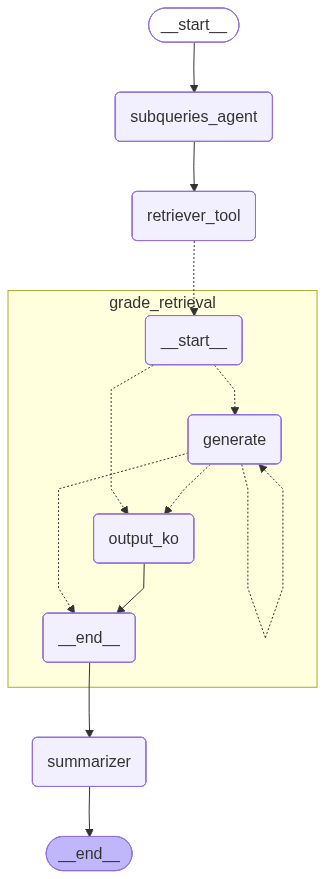

In [40]:
mdl_graph = StateGraph(
    state_schema= MdlState,
    input_schema= MdlState,
    output_schema= MdlOutputState
)

mdl_graph.add_node('subqueries_agent', generate_mdl_sub_queries)
mdl_graph.add_node('retriever_tool', retrieve_mdl_queries)
mdl_graph.add_node('grade_retrieval', grading_generation_graph)
mdl_graph.add_node('summarizer', summarize_mdl)
# mdl_graph.add_node('output_ko', set_mdl_ko)

mdl_graph.add_edge(START, 'subqueries_agent')
mdl_graph.add_edge('subqueries_agent', 'retriever_tool')
mdl_graph.add_conditional_edges('retriever_tool', send_to_parallel_grade, ['grade_retrieval'])
# mdl_graph.add_conditional_edges('grade_retrieval', exists_generation)
mdl_graph.add_edge('grade_retrieval', 'summarizer')
mdl_graph.add_edge('summarizer', END)
# mdl_graph.add_edge('output_ko', END)


mdl_graph = mdl_graph.compile()

display(Image(mdl_graph.get_graph(xray=1).draw_mermaid_png()))

In [41]:
user_query = 'The name of the product with highest sales.'

mdl_test = mdl_graph.invoke({
    "user_query": user_query,
    'language': 'English'
})['data_schema']

Markdown(mdl_test)

---MDL SUB-QUERIES---
---MDL RETRIEVE TOOL---


No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75
No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---CHECK ITERAT

### Relevant Tables and Columns

#### Table: `dim_product`
- **Description**: Dimension table storing detailed information about each product ever sold.
- **Primary Key**: `product_key`
- **Columns**:
  - `english_product_name` (VARCHAR(50)): Name of the product in English. **Never NULL**.
  - `spanish_product_name` (VARCHAR(50)): Name of the product in Spanish. **Can be NULL**.
  - `list_price` (NUMERIC): Sale price of the product in USD.
  - `dealer_price` (NUMERIC): Distributor price in USD.
  - `standard_cost` (NUMERIC): Standard cost of the product in USD.

#### Table: `fact_sales`
- **Description**: Contains detailed records of delivered sales orders at the line level.
- **Primary Keys**:
  - `sales_order_number`
  - `sales_order_line_number`
- **Foreign Keys**:
  - `product_key` → `dim_product.product_key`
- **Columns**:
  - `sales_amount` (NUMERIC): Represents the subtotal in USD for the sales order line. **Never NULL**.
  - `product_key` (Foreign Key): Links to the `dim_product` table.

### Relationships and SQL Join Conditions

To determine the product with the highest sales amount:
1. Aggregate `sales_amount` grouped by `product_key` in the `fact_sales` table.
2. Use the foreign key `product_key` to join with the `dim_product` table to retrieve the product name.

#### SQL Join Condition
- `fact_sales.product_key = dim_product.product_key`

### Grafo de Generación de Contexto

#### LLM's

##### Language Detection

In [42]:
class DefineLanguageResult(BaseModel):
    """Detect the language of the user query."""

    language: str = Field(
        description= "Language of user query in English, e.g. Spanish, English, etc."
    )

structured_llm_language_detector = llm_classifiers.with_structured_output(DefineLanguageResult)

language_system_prompt = """
Your goal is to identify the language of the user's query and respond with \
only the name of that language in English. Do not include any other text or punctuation.

### Example User Query:

"¿Qué hora es?"

### Your Expected Response:

Spanish
"""

language_prompt = ChatPromptTemplate.from_messages([
    ("system", language_system_prompt),
    ("human", "{user_query}")
])

language_detector = language_prompt | structured_llm_language_detector


print('Spanish user_query:')
spanish_user_query = '¿Cuál es el promedio de ventas por producto?'
print(f"'{spanish_user_query}'")
print(language_detector.invoke({"user_query": spanish_user_query}))

print('\n' + '-'*100 + '\n')

print('English user_query:')
english_user_query = 'Tell me the average value of sales by products.'
print(f"'{english_user_query}'")
print(language_detector.invoke({"user_query": english_user_query}))

Spanish user_query:
'¿Cuál es el promedio de ventas por producto?'
language='Spanish'

----------------------------------------------------------------------------------------------------

English user_query:
'Tell me the average value of sales by products.'
language='English'


##### Final Summarizer

In [43]:
class GlobalContextSummaryResult(BaseModel):
    """Relevant global summary generated from business logic and tables schemas based in user query."""
    generated_context: str = Field(
        description= "Global summary of business logic and tables schemas relevant for a data analyst SQL query confection."
    )

structured_llm_global_context_generator = llm_generation.with_structured_output(GlobalContextSummaryResult)


global_context_generator_system_prompt = """
You are a highly precise and diligent Ultimate Data & Business Synthesis Agent. \
Your sole purpose is to process and synthesize complex information from two distinct sources: \
a **Data Schema** (tables, columns, and relationships) and **Business Logic** (rules and concepts). \
Your goal is to produce a single, comprehensive, and detailed output that consolidates all \
provided information into a unified, business-oriented view.

The final output is intended for a data analyst who will use it to build a structured SQL query. \
The response must be clear, precise, and contain all the necessary details to represent \
the table structures, relationships, and business rules accurately.

---

### INSTRUCTIONS

1. Strictly Adhere to Context: Your response must be derived exclusively from the information \
    provided in the [DATA_SCHEMA] and [BUSINESS_LOGIC] sections. You MUST NOT invent, infer, or \
    hallucinate any details, tables, columns, rules, or logic that are not explicitly present in the provided context.

2. Handle Lack of Context: If a context extract explicitly states that no relevant information is available, \
    you must ignore that extract. If all provided context extracts state that no relevant information is available, \
    your final output must be a single, brief sentence stating that no relevant tables, columns, \
    or business logic were found for the user's query.

3. Ensure Full Coverage: Every single piece of relevant information from both the data schema and \
    the business logic context must be incorporated into your final output. Leave no detail unaddressed.

4. Language-Specific Prioritization & Synergy: You MUST prioritize providing all potentially relevant information \
    while ensuring it aligns with the user's query language defined in {language}. The guiding principle is to include \
    more data rather than risk omitting valuable details, but with an intelligent filter for language.

    - Data Schema: Include all tables and columns from the [DATA_SCHEMA] that have any potential relevance to the user's query.
    - Business Logic: Incorporate all business rules and concepts from the [BUSINESS_LOGIC] context.
    - Cross-Reference: You MUST ensure that any table or column from the [DATA_SCHEMA] that is explicitly named or \
        referenced within the [BUSINESS_LOGIC] context is included in your final output. \
        Highlight these connections to provide a clear, business-oriented view for the analyst.
    - Language-Specific Translation: If the context provides language-specific information \
        (e.g., column names, placeholder values, or SQL fragments) that do not match the {language} \
        of the user's query, \you MUST translate or adapt this information to the target language. \
        For example, if the query is in English and a rule mentions a placeholder "No registrado", \
        you should adapt it to a relevant English equivalent like "Not Registered". \
        Similarly, if a SQL fragment uses a Spanish alias, you must provide the English equivalent.

5. Column Details: For all relevant columns, you MUST include information regarding their data type, \
    nullability (e.g., NOT NULL), and any expected values or constraints explicitly mentioned in the context.

6. SQL Handling: You MUST INCLUDE any SQL fragments or clauses that are explicitly present in the \
    [DATA_SCHEMA] and [BUSINESS_LOGIC] contexts. You are ABSOLUTELY FORBIDDEN FROM INVENTING, EXTRACTING, \
    OR SUGGESTING any new SQL query or complete SQL code not provided in the source material. \
    You may only provide relevant fragments or logical components of SQL that are directly derived \from the provided information.

7. Language: The output MUST be a text in **{language}**.

8. Purpose-Oriented Output: The response must be clear, precise, and contain all the necessary details \
    to represent the table structure, relationships, and business rules accurately. Organize the information \
    logically using markdown headings, subheadings, and bullet points to facilitate easy understanding \
    and translation into a query structure.

---

### INPUT

[USER_QUERY]
<user_query>
{user_query}
</user_query>

[BUSINESS_LOGIC]
<business_logic>
{business_logic}
</business_logic>

[DATA_SCHEMA]
<data_schema>
{data_schema}
</data_schema>

---

### OUTPUT

Your final output should be a single, structured text with three main sections:
1. A brief, high-level summary of the business goal and the relevant data assets.
2. A detailed breakdown of all relevant tables and columns, along with their relationships.
3. A summary of the relevant business rules, and how they relate to the tables and columns.

Ensure every detail from both contexts is accounted for and explained in a logical flow. \
The output should empower the data analyst to construct the query without needing external information.
"""

global_context_prompt = ChatPromptTemplate.from_template(
    global_context_generator_system_prompt
)

global_context_generator = global_context_prompt | structured_llm_global_context_generator

user_query = 'The product most selled.'

business_logic = """
### Synthesized Business Logic

#### High-Level Summary
The query seeks to identify the product that has been sold the most, which can be measured by the quantity of units sold (`order_quantity`).

#### Detailed Breakdown

- **Metric Definition**:
  - The term "most sold" refers to the product with the highest quantity of units sold (`order_quantity`).
  - If the query specifies "highest revenue," the metric would shift to the total sales amount (`sales_amount`).

- **Entity Representation**:
  - For product representation, prioritize the `_name` fields, using Spanish names if available, and fallback to English names if not.
  - Example SQL for product name representation:
    ```sql
    SELECT
        product_key,
        COALESCE(spanish_product_name, english_product_name) AS producto_nombre
    FROM
        sales.dim_product;
    ```

- **Handling Null Values**:
  - For attributes like `product_line`, `class`, and `style`, replace null values with placeholders indicating "not registered" in the query's language.
  - Example SQL for handling null values:
    ```sql
    SELECT
        product_key,
        COALESCE(product_line, '|| No registrado ||') AS producto_linea
    FROM
        sales.dim_product;
    ```

This synthesized logic provides the necessary details to construct a SQL query to identify the most sold product based on the provided context.
"""

data_schema = """
### Detailed Summary of Relevant Tables and Columns

#### Table: `dim_product`
- **Description**: Dimension table storing detailed information about each product ever sold. Relevant for queries listing products by name.
- **Primary Key**: `product_key`
- **Columns**:
  - `english_product_name` (VARCHAR(50)): Name of the product in English. This column is never NULL.
  - `dealer_price` (NUMERIC): Distributor price in USD. Nullability not specified.

#### Table: `fact_sales`
- **Description**: Contains detailed sales order information at the line level, always showing the latest version of each order. It is the primary source for sales data such as quantities sold, sales amounts, costs, taxes, shipping costs, and more.
- **Primary Keys**: `sales_order_number`, `sales_order_line_number`
- **Foreign Keys**:
  - `product_key` → `sales.dim_product.product_key`
- **Columns**:
  - `sales_amount` (NUMERIC): Represents the subtotal in USD for the sales order line, calculated as `extended_amount - discount_amount`. Nullability not specified.
  - `product_key` (Foreign Key): Links to the product dimension table. Nullability not specified.

### Relationships and SQL Join Conditions
To determine the product with the highest sales amount:
1. Use the `fact_sales` table as the primary source.
2. Aggregate `sales_amount` grouped by `product_key`.
3. Join with the `dim_product` table using `fact_sales.product_key = dim_product.product_key` to retrieve the product name.
"""

# business_logic = "No relevant business logic to the user query."
# data_schema = "No relevant tables nor columns to the user query."

print(global_context_generator.invoke({
    "user_query": user_query,
    "language": 'English',
    "business_logic": business_logic,
    "data_schema": data_schema
}).generated_context)

### Comprehensive Context for Query: "The product most sold"

#### High-Level Summary
The query aims to identify the product that has been sold the most, measured by the quantity of units sold (`order_quantity`).

#### Relevant Tables and Columns

##### Table: `dim_product`
- **Description**: Dimension table storing detailed information about each product.
- **Primary Key**: `product_key`
- **Columns**:
  - `english_product_name` (VARCHAR(50), NOT NULL): Name of the product in English.
  - `dealer_price` (NUMERIC): Distributor price in USD.

##### Table: `fact_sales`
- **Description**: Contains detailed sales order information at the line level.
- **Primary Keys**: `sales_order_number`, `sales_order_line_number`
- **Foreign Keys**:
  - `product_key` → `dim_product.product_key`
- **Columns**:
  - `sales_amount` (NUMERIC): Subtotal in USD for the sales order line.
  - `product_key` (Foreign Key): Links to the product dimension table.

#### Relationships
- The `fact_sales` table links to 

##### No Relevant Context Message Generator

In [44]:
class NoRelevantContextResult(BaseModel):
    """
    Generate a concise apology to the user when the AI's knowledge base lacks relevant information
    to answer the query. The message should include some example topics the AI can discuss.
    """

    no_context_message: str = Field(
        description= (
            "A polite and apologetic message to the user, explaining that the current "
            "knowledge base does not contain information on the topic. The message must "
            "also offer to answer questions on other topics based in the context bringed."
        )
    )

structured_llm_no_context_replier = llm_retrievals.with_structured_output(NoRelevantContextResult)

no_context_response_system_prompt = """
You are an AI assistant designed to respond to users when their queries cannot be \
answered due to a lack of relevant context. Your sole task is to generate a polite \
apology and offer to help with other topics that are within your knowledge domain.

---

### INSTRUCTIONS

1.  **Core Task:** Your only job is to generate a response. \
    Do not try to answer the original user query.

2.  **Apology:** Start with a polite apology, clearly stating that \
    you cannot answer the user's question.

3.  **Reason:** Explain that the topic is outside the scope \
    of your current knowledge base.

4.  **Offer of Help:** Based on the provided context, offer \
    to answer questions that are relevant to the data warehouse.

5.  **Examples:** Include 2 or 3 specific examples of topics you can answer, \
    pulling directly from the concepts mentioned in the context. \
    For instance, if the context mentions "sales data" or "product inventory," \
    use these as examples.

6.  **Language:** The output MUST be a text in **{language}**.

---

### INPUT

[USER_QUERY]
<user_query>
{user_query}
</user_query>

[CONTEXT]
<context>
{context}
</context>
"""

no_context_prompt = ChatPromptTemplate.from_template(no_context_response_system_prompt)

no_context_replier = no_context_prompt | structured_llm_no_context_replier


user_query = '¿Cuál es el departamento con salario medio más elevado?'

doc_txt = """
3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la métrica clave es el margen bruto (`gross margin`) o el porcentaje de margen bruto (`gross margin percentage`), lo cual permite comprender la contribución real de cada venta o producto a las ganancias, más allá del volumen o ingreso total. Este enfoque es vital para evaluar la eficiencia operativa.
- En el contexto de la gestión de promociones, el éxito no solo se mide por el discount_amount o average_discount_rate, sino también por el incremento en `order_quantity` o `sales_amount` directamente atribuible a la promoción. Es fundamental analizar la rentabilidad general del período promocional para determinar su efectividad.
- Ventas B2C (Business-to-Consumer): Estas ventas se refieren a transacciones directas con el consumidor final. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'internet_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio minorista.
- Ventas B2B (Business-to-Business): Estas ventas se refieren a transacciones entre empresas, como las realizadas con distribuidores o tiendas minoristas. En el modelo, corresponden a los pedidos donde `sale_source` es igual a `'reseller_sales'`. Puede identificarse también como la unidad de negocio encargada del comercio mayorista.
"""

print('User Query:')
print(f"'{user_query}'", end='\n\n')
print('Context:')
print(doc_txt, end='\n\n')
print(no_context_replier.invoke({
    "user_query": user_query,
    "language": 'Spanish',
    "context": doc_txt,
}).no_context_message)

User Query:
'¿Cuál es el departamento con salario medio más elevado?'

Context:

3. Métricas Clásicas del Retail y su Interpretación

Es crucial entender cómo se miden las diferentes métricas en el contexto de negocio.- Cuando se habla de productos "más vendidos", sin especificar más, generalmente nos referimos a la cantidad de unidades (`order_quantity`) vendidas. También puede ser relevante medir esto por el importe facturado (`sales_amount`) para identificar productos que, aunque se vendan en menor volumen, generan más ingresos. Pero, en este último caso se especificarán términos como "de mayor facturación".
- Cuando se refiere a clientes, tiendas/distribuidores o vendedores que "más compran/venden", esto se mide por el importe facturado (`sales_amount`) o `net sales`. Adicionalmente, se puede considerar la frecuencia de compra (para clientes y distribuidores) o el número de pedidos gestionados (para vendedores) como métricas complementarias.
- Para el análisis de rentabilidad, la m

#### Estado

In [58]:
class ContextGeneratorState(TypedDict):
    user_query: str
    language: str
    context_generation_iterations: int
    business_logic: str
    data_schema: str
    relevant_context: bool
    context: str
    context_retrieved_summary: str
    no_relevant_context_msg: str
    mdl_retrieval_results: List[Dict[str, str]]
    business_logic_retrieval_results: List[str]

class ContextGeneratorOutputState(TypedDict):
    language: str
    relevant_context: bool
    context: str
    no_relevant_context_msg: str


#### Nodos

In [80]:
def detect_user_query_language(state: ContextGeneratorState):
    """
    Define the language of the user query.

    Args:
        state (dict): The current graph state
    """
    print("---DEFINE LANGUAGE---")
    user_query = state['user_query']
    context_generation_iterations = state.get('context_generation_iterations', 0)
    
    language = language_detector.invoke({
            'user_query': user_query
    }).language

    return {
        'language': language,
        'context_generation_iterations': context_generation_iterations + 1,
    }


def generate_global_context(state: ContextGeneratorState):
    """
    Generate a global context based on Business Logic and Data Schema results.

    Args:
        state (dict): The current graph state
    """
    print("---GLOBAL CONTEXT GENERATION---")
    
    user_query = state['user_query']
    language = state['language']
    business_logic = state['business_logic']
    data_schema = state['data_schema']

    context = global_context_generator.invoke({
        "user_query": user_query,
        "language": language,
        "business_logic": business_logic,
        "data_schema": data_schema
    }).generated_context

    return {
        'context': context
    }


def grade_context_summaries(state: ContextGeneratorState):
    """
    Determines whether the generation is grounded in the 
    document and informative for question.

    Args:
        state (dict): The current graph state
    """
    print("---GRADING CONTEXT SUMMARIES---")
    
    user_query = state['user_query']
    business_logic_retrieval_results = state['business_logic_retrieval_results']
    mdl_retrieval_results = state['mdl_retrieval_results']

    context_list = ['### Business Logic Context']
    context_list.extend([business_logic_txt for business_logic_txt in business_logic_retrieval_results])
    context_list.append('### Tables Context')
    context_list.extend([
        '\n'.join(table['table_summary'].split('\n')[2:])
        for table in mdl_retrieval_results
    ])

    context_retrieved_summary = '\n\n---\n\n'.join(context_list)

    relevant_context = retrieval_grader.invoke({
        'user_query': user_query,
        'context': context_retrieved_summary
    }).relevant

    return {
        'context_retrieved_summary': context_retrieved_summary,
        'relevant_context': relevant_context,
    }


def generate_no_context_response(state: ContextGeneratorState):
    """
    When do not exist any relevant context, generate an 
    explanation for the user with examples.

    Args:
        state (dict): The current graph state
    """
    print("---NO RELEVANT CONTEXT RESPONSE GENERATION---")
    
    user_query = state['user_query']
    language = state['language']
    context_retrieved_summary = state['context_retrieved_summary']

    no_relevant_context_msg = no_context_replier.invoke({
        "user_query": user_query,
        "language": language,
        "context": context_retrieved_summary,
    }).no_context_message

    return {
        'no_relevant_context_msg': no_relevant_context_msg
    }

#### Conditional Edges

In [81]:
def route_context_relevance(state: ContextGeneratorState) -> Literal['get_global_context', 'get_no_relevance_response']:
    """
    Route the flow between generate the global context, or generate the no relevant context reply.

    Args:
        state (dict): The current graph state

    Results:
        The next step alias.
    """
    return (
        'get_global_context'
        if state['relevant_context'] else
        'get_no_relevance_response'
    )

#### Grafo

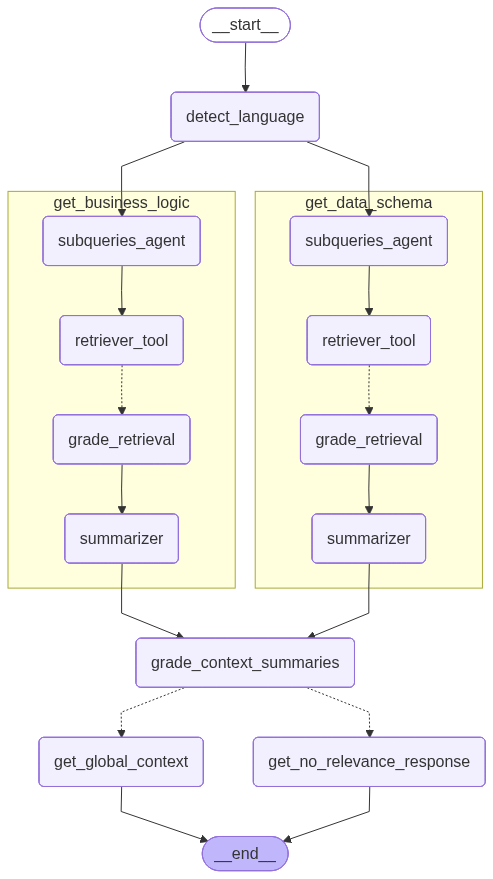

In [82]:
context_generation_graph = StateGraph(
    state_schema= ContextGeneratorState,
    input_schema= ContextGeneratorState,
    output_schema= ContextGeneratorOutputState
)

context_generation_graph.add_node('detect_language', detect_user_query_language)
context_generation_graph.add_node('get_business_logic', business_logic_graph)
context_generation_graph.add_node('get_data_schema', mdl_graph)
context_generation_graph.add_node('grade_context_summaries', grade_context_summaries)
context_generation_graph.add_node('get_global_context', generate_global_context)
context_generation_graph.add_node('get_no_relevance_response', generate_no_context_response)

context_generation_graph.add_edge(START, 'detect_language')
context_generation_graph.add_edge('detect_language', 'get_business_logic')
context_generation_graph.add_edge('detect_language', 'get_data_schema')
context_generation_graph.add_edge('get_business_logic', 'grade_context_summaries')
context_generation_graph.add_edge('get_data_schema', 'grade_context_summaries')
context_generation_graph.add_conditional_edges('grade_context_summaries', route_context_relevance)
context_generation_graph.add_edge('get_global_context', END)
context_generation_graph.add_edge('get_no_relevance_response', END)


context_generation_graph = context_generation_graph.compile()

display(Image(context_generation_graph.get_graph(xray=1).draw_mermaid_png()))

In [85]:
user_query = 'Dime las ventas del último trimestre detallas por categorías de producto.'

global_context_test = context_generation_graph.invoke({
    "user_query": user_query
})

global_context_test

---DEFINE LANGUAGE---
---BUSINESS LOGIC SUB-QUERIES---
---MDL SUB-QUERIES---
---BUSINESS LOGIC RETRIEVE TOOL---
---MDL RETRIEVE TOOL---


No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---


No relevant docs were retrieved using the relevance score threshold 0.75


---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---


No relevant docs were retrieved using the relevance score threshold 0.75


---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
---GENERATE---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---


No relevant docs were retrieved using the relevance score threshold 0.75


---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---CHECK ITERATIONS---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
---GENERATE---


No relevant docs were retrieved using the relevance score threshold 0.75


---PARALLELIZE GENERATION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---CHECK ITERATIONS---
---SET GRADE OUTPUT KO---
---BUSINES LOGIC SUMMARIZING---
---GRADE: DOCUMENT NOT RELEVANT---
---SET GRADE OUTPUT KO---
---GRADE: DOCUMENT NOT RELEVAN

{'language': 'Spanish',
 'relevant_context': True,
 'context': "### Resumen de la Meta de Negocio y Activos de Datos\n\nLa consulta busca obtener las ventas del último trimestre detalladas por categorías de producto. Para ello, se utilizarán las tablas y columnas relevantes del esquema de datos proporcionado, junto con las reglas de negocio relacionadas con la definición de trimestres y la manipulación de fechas en SQL.\n\n### Detalle de Tablas y Columnas Relevantes\n\n#### Tabla: `fact_sales`\n- **Descripción:** Contiene el detalle de las órdenes de ventas entregadas, con granularidad a nivel de línea.\n- **Columnas relevantes:**\n  - `sales_amount` (NUMERIC): Subtotal en USD de la línea de orden de venta.\n  - `order_date` (DATE): Fecha de creación del pedido.\n  - `product_key` (INT): Llave foránea hacia la tabla `dim_product`.\n\n#### Tabla: `dim_product`\n- **Descripción:** Contiene información sobre los productos.\n- **Columnas relevantes:**\n  - `product_key` (INT): Llave primar

In [87]:
Markdown("### Resumen de la Meta de Negocio y Activos de Datos\n\nLa consulta busca obtener las ventas del último trimestre detalladas por categorías de producto. Para ello, se utilizarán las tablas y columnas relevantes del esquema de datos proporcionado, junto con las reglas de negocio relacionadas con la definición de trimestres y la manipulación de fechas en SQL.\n\n### Detalle de Tablas y Columnas Relevantes\n\n#### Tabla: `fact_sales`\n- **Descripción:** Contiene el detalle de las órdenes de ventas entregadas, con granularidad a nivel de línea.\n- **Columnas relevantes:**\n  - `sales_amount` (NUMERIC): Subtotal en USD de la línea de orden de venta.\n  - `order_date` (DATE): Fecha de creación del pedido.\n  - `product_key` (INT): Llave foránea hacia la tabla `dim_product`.\n\n#### Tabla: `dim_product`\n- **Descripción:** Contiene información sobre los productos.\n- **Columnas relevantes:**\n  - `product_key` (INT): Llave primaria.\n  - `product_category` (TEXT): Categoría del producto.\n\n#### Relación entre tablas\n- `fact_sales.product_key = dim_product.product_key`\n\n### Reglas de Negocio Relevantes\n\n#### Definición de Trimestre\n- Un trimestre es un período de tres meses. Los trimestres del año natural son:\n  - Q1: Enero-Marzo\n  - Q2: Abril-Junio\n  - Q3: Julio-Septiembre\n  - Q4: Octubre-Diciembre\n\n#### Manipulación de Fechas en SQL\n- PostgreSQL soporta funciones como `DATE_TRUNC('quarter', date)` para manipulación de fechas.\n- `INTERVAL` se utiliza para operaciones de tiempo.\n\n#### Ejemplo de Consulta SQL\n```sql\nSELECT dp.product_category, SUM(fs.sales_amount) AS total_sales\nFROM fact_sales fs\nJOIN dim_product dp ON fs.product_key = dp.product_key\nWHERE fs.order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day'\nGROUP BY dp.product_category;\n```\n\nEste ejemplo calcula las ventas del trimestre anterior agrupadas por categoría de producto, utilizando las columnas y relaciones descritas.")

### Resumen de la Meta de Negocio y Activos de Datos

La consulta busca obtener las ventas del último trimestre detalladas por categorías de producto. Para ello, se utilizarán las tablas y columnas relevantes del esquema de datos proporcionado, junto con las reglas de negocio relacionadas con la definición de trimestres y la manipulación de fechas en SQL.

### Detalle de Tablas y Columnas Relevantes

#### Tabla: `fact_sales`
- **Descripción:** Contiene el detalle de las órdenes de ventas entregadas, con granularidad a nivel de línea.
- **Columnas relevantes:**
  - `sales_amount` (NUMERIC): Subtotal en USD de la línea de orden de venta.
  - `order_date` (DATE): Fecha de creación del pedido.
  - `product_key` (INT): Llave foránea hacia la tabla `dim_product`.

#### Tabla: `dim_product`
- **Descripción:** Contiene información sobre los productos.
- **Columnas relevantes:**
  - `product_key` (INT): Llave primaria.
  - `product_category` (TEXT): Categoría del producto.

#### Relación entre tablas
- `fact_sales.product_key = dim_product.product_key`

### Reglas de Negocio Relevantes

#### Definición de Trimestre
- Un trimestre es un período de tres meses. Los trimestres del año natural son:
  - Q1: Enero-Marzo
  - Q2: Abril-Junio
  - Q3: Julio-Septiembre
  - Q4: Octubre-Diciembre

#### Manipulación de Fechas en SQL
- PostgreSQL soporta funciones como `DATE_TRUNC('quarter', date)` para manipulación de fechas.
- `INTERVAL` se utiliza para operaciones de tiempo.

#### Ejemplo de Consulta SQL
```sql
SELECT dp.product_category, SUM(fs.sales_amount) AS total_sales
FROM fact_sales fs
JOIN dim_product dp ON fs.product_key = dp.product_key
WHERE fs.order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day'
GROUP BY dp.product_category;
```

Este ejemplo calcula las ventas del trimestre anterior agrupadas por categoría de producto, utilizando las columnas y relaciones descritas.